## **Imporant: (Changes made in CNN-LSTM listed below)

* Preprocessing: dropped null values instead of imputing by 0s
* Keeping loss='mae' in CNN-LSTM
* Resampling technique = Weekly
* Same training & test set have been used for CNN-LSTM & LSTM

### Time-Series Analysis using CNN-LSTM: Dhaka Tribune

Dataset: Dhaka Tribune 2021 Dataset

Author: Sumaia Parveen Shupti

Created on: 07/10/2021

Updated on: 08/02/2021

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

### Load & Preprocess Dataset

In [2]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df.columns = ['Period', 'Deaths']
df = df.dropna()
df = df.sort_values(by = 'Period')
df = df.reset_index(drop = True).set_index('Period').resample('1W').sum()
df = df.reset_index()
df['Period'] = df['Period'].dt.date
#df['Deaths'] = df['Deaths'].fillna(0)
df = df.set_index('Period')
df

,Deaths
Period,
2016-06-26,3.0
2016-07-03,0.0
2016-07-10,0.0
2016-07-17,4.0
2016-07-24,0.0
...,...
2021-05-30,3.0
2021-06-06,11.0
2021-06-13,8.0


### Splitting into Train & Test Sets

In [3]:
start_ = df.index.max()
end_ = df.index.min()

test_end = df.index.max()
test_start = df.index.max() - timedelta(days = 60)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 365*5)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-27
Dataset End Date: 2016-06-26
 
Train Set Start Date: 2016-04-28
Train Set End Date: 2021-04-27
 
Test Set Start Date: 2021-04-28
Test Set End Date: 2021-06-27
 


In [4]:
mask = (df.index > train_start) & (df.index <= train_end)
train = df.loc[mask]

mask = (df.index > test_start) & (df.index <= test_end)
test = df.loc[mask]

In [5]:
d = pd.concat([train, test])
d = d.reset_index()
d

,Period,Deaths
0,2016-06-26,3.0
1,2016-07-03,0.0
2,2016-07-10,0.0
3,2016-07-17,4.0
4,2016-07-24,0.0
...,...,...
257,2021-05-30,3.0
258,2021-06-06,11.0
259,2021-06-13,8.0
260,2021-06-20,16.0


### Transform the data into a time series problem

In [6]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### We will use the present day and the last 3 days data to forecast 1 day's results ahead

In [7]:
window = 2
lag = 1
series = series_to_supervised(d.drop('Period', axis=1), window=window, lag=lag)
series

,Deaths(t-2),Deaths(t-1),Deaths(t),Deaths(t+1)
2,3.0,0.0,0.0,4.0
3,0.0,0.0,4.0,0.0
4,0.0,4.0,0.0,0.0
5,4.0,0.0,0.0,3.0
6,0.0,0.0,3.0,1.0
...,...,...,...,...
256,11.0,20.0,28.0,3.0
257,20.0,28.0,3.0,11.0
258,28.0,3.0,11.0,8.0
259,3.0,11.0,8.0,16.0


In [8]:
lag_size = 1

# Label
labels_col = 'Deaths(t+%d)' % lag_size
labels = series[[labels_col]]
series = series.drop(labels_col, axis=1)
series

,Deaths(t-2),Deaths(t-1),Deaths(t)
2,3.0,0.0,0.0
3,0.0,0.0,4.0
4,0.0,4.0,0.0
5,4.0,0.0,0.0
6,0.0,0.0,3.0
...,...,...,...
256,11.0,20.0,28.0
257,20.0,28.0,3.0
258,28.0,3.0,11.0
259,3.0,11.0,8.0


In [9]:
labels

,Deaths(t+1)
2,4.0
3,0.0
4,0.0
5,3.0
6,1.0
...,...
256,3.0
257,11.0
258,8.0
259,16.0


In [10]:
X_train = series[:len(train)- window]
X_train

,Deaths(t-2),Deaths(t-1),Deaths(t)
2,3.0,0.0,0.0
3,0.0,0.0,4.0
4,0.0,4.0,0.0
5,4.0,0.0,0.0
6,0.0,0.0,3.0
...,...,...,...
248,5.0,14.0,26.0
249,14.0,26.0,7.0
250,26.0,7.0,4.0
251,7.0,4.0,25.0


In [11]:
Y_train = labels[:len(train)- window]
Y_train

,Deaths(t+1)
2,4.0
3,0.0
4,0.0
5,3.0
6,1.0
...,...
248,7.0
249,4.0
250,25.0
251,6.0


In [12]:
X_valid = series[len(train)- window:]
X_valid

,Deaths(t-2),Deaths(t-1),Deaths(t)
253,25.0,6.0,12.0
254,6.0,12.0,11.0
255,12.0,11.0,20.0
256,11.0,20.0,28.0
257,20.0,28.0,3.0
258,28.0,3.0,11.0
259,3.0,11.0,8.0
260,11.0,8.0,16.0


In [13]:
Y_valid = labels[len(train)- window:]
Y_valid

,Deaths(t+1)
253,11.0
254,20.0
255,28.0
256,3.0
257,11.0
258,8.0
259,16.0
260,5.0


In [14]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

print('Train labels shape', Y_train.shape)
print('Validation labels shape', Y_valid.shape)

Train set shape (251, 3)
Validation set shape (8, 3)
Train labels shape (251, 1)
Validation labels shape (8, 1)


In [15]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (251, 3, 1)
Validation set shape (8, 3, 1)


In [16]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (251, 1, 3, 1)
Validation set shape (8, 1, 3, 1)


### Model Development: CNN-LSTM

In [17]:
epochs = 100
batch = 1
lr = 0.008
adam = optimizers.Adam(lr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=70)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [18]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=100, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
#model_cnn_lstm.add(LSTM(50,activation="relu",return_sequences=True))
#model_cnn_lstm.add(Dropout(0.15))
#model_cnn_lstm.add(LSTM(50,activation="relu",return_sequences=True))
model_cnn_lstm.add(LSTM(50,activation="relu"))
model_cnn_lstm.add(Dropout(0.15))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mae', optimizer='adam')

In [19]:
%%time
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=1, callbacks=[es, mcp])

Epoch 1/100
8/8 [==============================] - 2s 94ms/step - loss: 12.3194 - val_loss: 9.8092

Epoch 00001: val_loss improved from inf to 9.80915, saving model to weights.h5
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 10.7382 - val_loss: 7.6919

Epoch 00002: val_loss improved from 9.80915 to 7.69185, saving model to weights.h5
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 9.7691 - val_loss: 7.7563

Epoch 00003: val_loss did not improve from 7.69185
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 10.6814 - val_loss: 8.0602

Epoch 00004: val_loss did not improve from 7.69185
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 10.1655 - val_loss: 8.1397

Epoch 00005: val_loss did not improve from 7.69185
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 8.7311 - val_loss: 8.0229

Epoch 00006: val_loss did not improve from 7.69185
Epoch 7/100
8/8 [===================

In [20]:
%%time
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)

CPU times: user 179 ms, sys: 5.77 ms, total: 185 ms
Wall time: 181 ms


In [21]:
comparison = test.copy()
comparison = comparison[:len(test)-lag]
comparison['Prediction'] = cnn_lstm_valid_pred
comparison['Prediction'] = round(comparison['Prediction'])
comparison

,Deaths,Prediction
Period,,
2021-05-02,12.0,11.0
2021-05-09,11.0,11.0
2021-05-16,20.0,15.0
2021-05-23,28.0,18.0
2021-05-30,3.0,8.0
2021-06-06,11.0,10.0
2021-06-13,8.0,8.0
2021-06-20,16.0,13.0


In [22]:
%%time
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)

CPU times: user 61.1 ms, sys: 3.55 ms, total: 64.7 ms
Wall time: 54.4 ms


In [23]:
comparison_train = train.copy()
comparison_train = comparison_train[window:]
comparison_train['Prediction'] = cnn_lstm_train_pred
comparison_train['Prediction'] = round(comparison_train['Prediction'])
comparison_train

,Deaths,Prediction
Period,,
2016-07-10,0.0,2.0
2016-07-17,4.0,3.0
2016-07-24,0.0,3.0
2016-07-31,0.0,3.0
2016-08-07,3.0,2.0
...,...,...
2021-03-28,26.0,13.0
2021-04-04,7.0,11.0
2021-04-11,4.0,9.0


### Visualization of Results

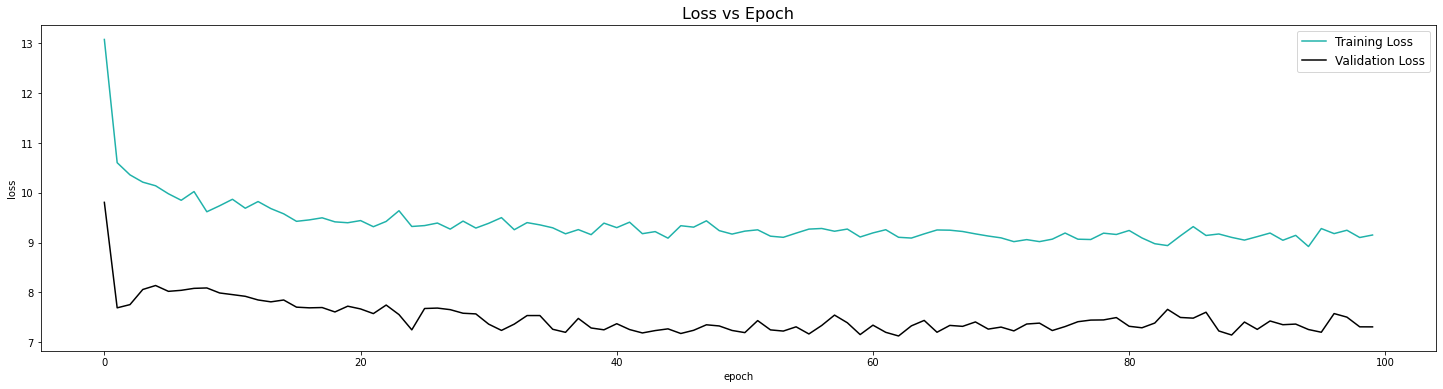

In [24]:
plt.rcParams["figure.figsize"] = [25, 6]

plt.plot(cnn_lstm_history.history['loss'], color = 'lightseagreen')
plt.plot(cnn_lstm_history.history['val_loss'], color = 'black')
plt.title('Loss vs Epoch', fontsize = 16)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best', fontsize = 'large')
plt.show()

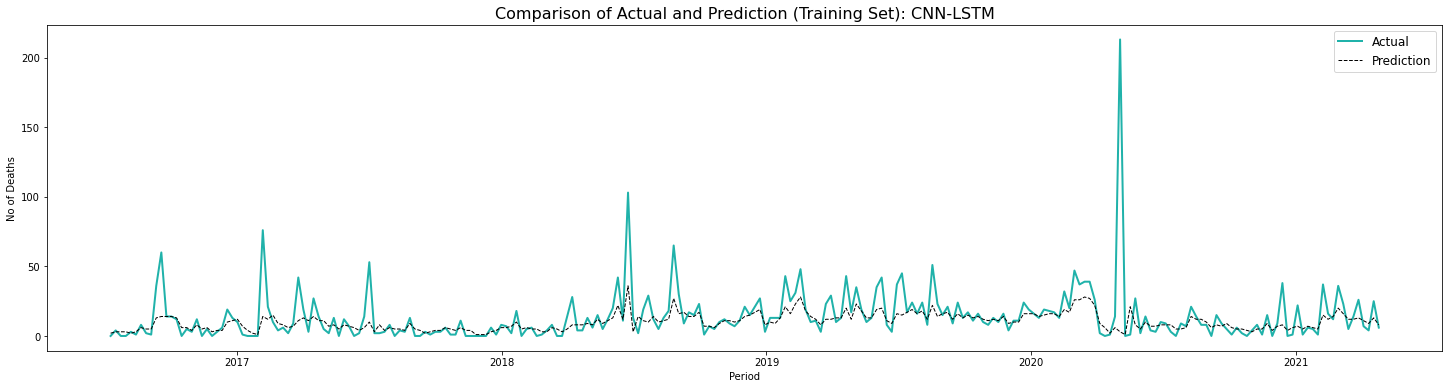

In [25]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison_train.Deaths.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison_train.Prediction.plot(linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction (Training Set): CNN-LSTM', fontsize = 16)
plt.show()

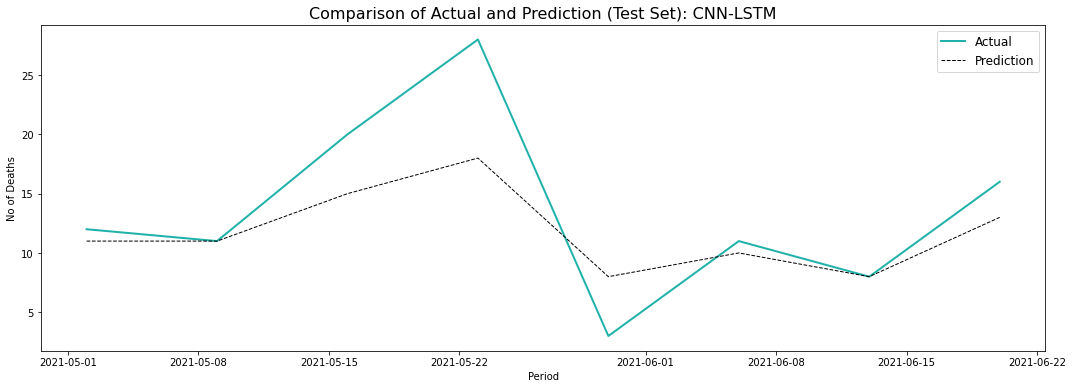

In [26]:
plt.rcParams["figure.figsize"] = [18, 6]

comparison.Deaths.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Prediction.plot(linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction (Test Set): CNN-LSTM', fontsize = 16)
plt.show()

### Evaluation Metrics: Training Set

In [27]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison_train['Deaths'] - comparison_train['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison_train['Deaths']).mean() * 100
r2 = r2_score(comparison_train['Deaths'], comparison_train['Prediction'])

In [28]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 7.0319
Mean Squared Error: 292.2590
Root Mean Square Error: 17.0956
Mean Absolute Percentage Error: inf
R2 Score: 0.1919


### Evaluation Metrics: Validation Set

In [29]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Deaths'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Deaths']).mean() * 100
r2 = r2_score(comparison['Deaths'], comparison['Prediction'])

In [30]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 3.1250
Mean Squared Error: 20.1250
Root Mean Square Error: 4.4861
Mean Absolute Percentage Error: 32.9444
R2 Score: 0.6110


### References

* https://colab.research.google.com/github/phylypo/TimeSeriesPrediction/blob/main/Time_Series_DL_LSTM_CNN.ipynb#scrollTo=LXuSM4llqGag